# Malaria
## A possible application of diversely generated DS-CycleGAN outputs

This notebook will generate cycleGAN-functional positive and negative malaria datasets from tfds's malaria dataset.
The following code will train a model, then load an existing malaria model that the user can visualize.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from trainer.config import config
from trainer.utils import dataset
from trainer.models import networks
from trainer import utils
from trainer import models
from trainer import callbacks

Unknown args: ['-f', '/home/jupyter/.local/share/jupyter/runtime/kernel-c66d78a8-7027-48de-a61c-b6dad8be969d.json']
Parsed args: {'generator_norm': 'instance', 'ds_count': 1067, 'buffer_size': 1000, 'ds_name': 'cycle_gan/horse2zebra', 'id_loss': 5, 'in_h': 256, 'discriminator_norm': 'instance', 'job_dir': 'gs://duke-bme590-cz/ds-cyclegan/tmp/1575516860.6398997', 'latent_z_dim': 8, 'is_test': False, 'ds_loss': 10, 'startLRdecay': 100, 'in_w': 256, 'model_dir': './trained_models', 'disc_loss': 1, 'bs': 1, 'cycle_consistency_loss': 10, 'epochs': 10, 'm': True}


In [2]:
train = tfds.load('malaria', split='train[:80%]')
test = tfds.load('malaria', split='train[-20%:]')

In [3]:
train_neg, train_pos, test_neg, test_pos = dataset.generate_malaria(train, test)

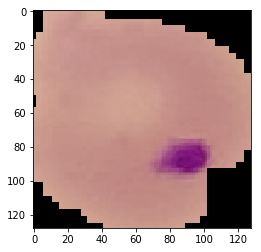

In [4]:
for x in train_pos: break
plt.imshow(np.squeeze(x))

In [5]:
LOG_DIR = 'trained_models/malaria/logs'
MODEL_DIR = 'trained_models/malaria/models'

g_AB = networks.bicycle_generator(img_shape=(128, 128, 3), z_shape=(config.latent_z_dim,), norm=config.generator_norm, skip=False, z_in='all')
g_BA = networks.bicycle_generator(img_shape=(128, 128, 3), z_shape=(config.latent_z_dim,), norm=config.generator_norm, skip=False, z_in='all')
d_A = networks.create_discriminator(shape=(128, 128, 3), norm=config.discriminator_norm)
d_B = networks.create_discriminator(shape=(128, 128, 3), norm=config.discriminator_norm)

In [6]:
dataset_count = 10999

model = models.DSGAN(shape = (None, None, 3),
                        g_AB=g_AB,
                        g_BA=g_BA,
                        d_B=d_B,
                        d_A=d_A)
model.compile(lr_g=2e-4, lr_d=2e-4,
              d_loss='mse',
              g_loss = [
                 'mse', 'mse',
                 'mae', 'mae',
                 'mae', 'mae'
              ], loss_weights = [
                 1,  1,
                 10, 10,
                 5, 5,
                 4, 4
              ],
              metrics=[utils.ssim])
def scheduler(epoch):
    if epoch < config.startLRdecay:
        return 2e-4
    else:
        epochs_passed = epoch - config.startLRdecay
        decay_step = 2e-4 / (config.epochs - config.startLRdecay)
        return 2e-4 - epochs_remaining * decay_step

# Generate Callbacks
LRscheduler = callbacks.MultiLRScheduler(scheduler, training_models=[model.d_A, model.d_B, model.combined])
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR, write_graph=True, update_freq='epoch')
start_tensorboard = callbacks.StartTensorBoard(LOG_DIR)
prog_bar = tf.keras.callbacks.ProgbarLogger(count_mode='steps', stateful_metrics=None)
log_code = callbacks.LogCode(LOG_DIR, './trainer')
copy_keras = callbacks.CopyKerasModel(MODEL_DIR, LOG_DIR)
saving = callbacks.MultiModelCheckpoint(MODEL_DIR + '/model.{epoch:02d}-{val_ssim:.10f}.hdf5',
                                        monitor='val_ssim', verbose=1, freq='epoch', mode='max', save_best_only=False,
                                        save_weights_only=True,
                                        multi_models=[('g_AB', g_AB), ('g_BA', g_BA), ('d_A', d_A), ('d_B', d_B)])
image_gen = callbacks.GenerateImages(g_AB, test_neg, test_pos, LOG_DIR, interval=int(dataset_count/config.bs), z_shape=(config.latent_z_dim,))

# Fit the model
model.fit(train_neg, train_pos,
          batch_size=config.bs,
          steps_per_epoch=(1000 // config.bs),
          epochs=100,
          validation_data=(test_neg, test_pos),
          validation_steps=10,
          callbacks=[log_code, tensorboard, prog_bar, image_gen, saving,
                     copy_keras, start_tensorboard])

Epoch 1/100
   1/1000 [..............................] - ETA: 5:51:53 - d_loss: 0.5111 - d_acc: 50.0000 - g_loss: 8.0696 - adv_loss: 0.9200 - recon_loss: 0.2080 - id_loss: 0.2080 - ds_loss: -0.0014

KeyboardInterrupt: 

Load existing model and visualize

In [ ]:
g_AB.load_weights("./trainer/trained_models/ds_malaria/g_AB.weights.hdf5")
g_BA.load_weights("./trainer/trained_models/ds_malaria/g_BA.weights.hdf5")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
def generate_images(model, test_input):
  z1 = tf.random.normal((1, 8))
  prediction = model([test_input, z1])
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

tf.Tensor(
[[ 0.62383753  0.8181421   1.7717395   0.39825052 -1.4219881   0.6659166
  -1.9902692   3.7997155 ]], shape=(1, 8), dtype=float32)
0.8745098
0.0
0.97380275
0.0


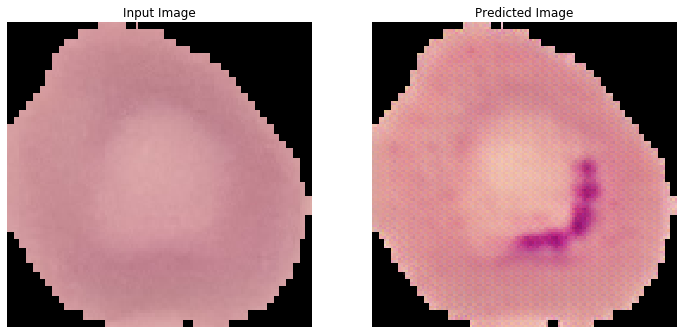

tf.Tensor(
[[ 0.25370607  1.0088013   0.5501095  -0.81441027  1.2030832  -0.7649091
  -1.1689947  -0.54065424]], shape=(1, 8), dtype=float32)
0.8627451
0.0
0.9229537
0.0


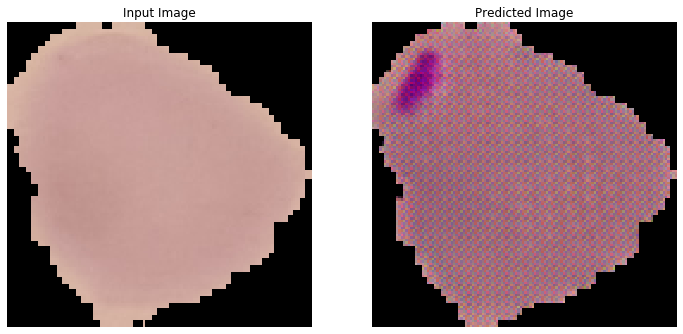

tf.Tensor(
[[ 0.6771162   0.75926197  0.8567637  -0.5667015   0.6325164   0.03263709
   1.4515511   0.45731664]], shape=(1, 8), dtype=float32)
0.8
0.0
0.9795159
0.0


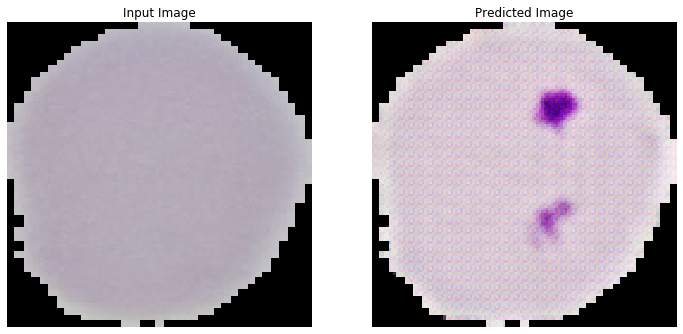

tf.Tensor(
[[-1.5824373   1.0677373   0.3277981  -0.3750527  -1.1444366   0.42194974
   0.02275793 -1.0105989 ]], shape=(1, 8), dtype=float32)
0.89411765
0.0
0.91727924
0.0


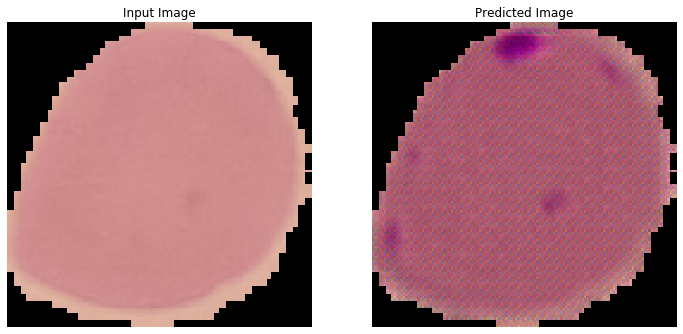

tf.Tensor(
[[ 0.01392953  0.8223673  -0.47527558 -0.63016444 -0.6609582   1.1118143
  -0.6606839   1.3541205 ]], shape=(1, 8), dtype=float32)
0.8784314
0.0
0.95208824
0.0


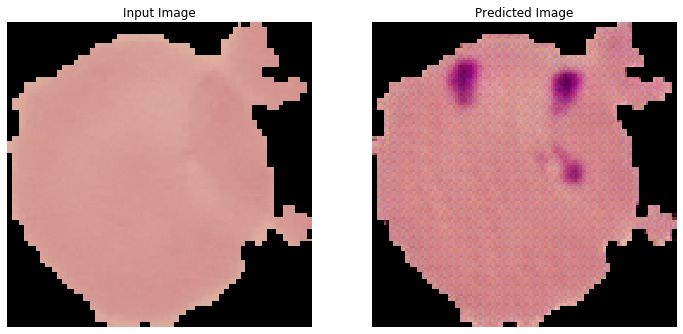

In [ ]:
# Run the trained model on the test dataset
for inp in test_neg.take(5):
  dataset.generate_images(g_AB, inp)